##<strong>문서 유사도 비교를 통한 군집분석</strong>

- 감정분석 모델은 총 11개의 감정을 분류, 분석된 감정에 대한 시각화 서비스 제공시 표현할 감정 결정을 위한 근거로서 해당 군집분석 결과 활용
  1. 감정분석 모델 생성시 사용한 감정 라벨링이 되어있는 데이터셋에 대해 문장 유사도를 비교한 후 군집분석 진행
    - 문서를 형태소 분리, 불용어 처리, 토큰화한 후 TF-IDF 매트릭스 구현
    - K-means를 이용하여 벡터화된 문서들 군집분석
    - 동일한 군집으로 묶인 문서들 간의 코사인 유사도(Cosine Similarity) 확인
  2. 같은 클러스터로 분류된 감정들은 통합하여 사용

In [52]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import glob
import os
import sklearn
import nltk

######<strong>데이터셋 전처리</strong>
- 감정 라벨링을 기준으로 결합하여 새로운 데이터 만들기
- 감정 라벨링:
  - '슬픔':0, '중립':1, '불안':2, '당황':3, '분노':4, '기쁨':5, '혐오':6, '상처':7, '행복':8, '놀람':9, '공포':10

In [54]:
# 데이터셋 불러오기
total_train = pd.read_csv('/content/drive/MyDrive/data/total_train_real.csv')
total_test = pd.read_csv('/content/drive/MyDrive//data/total_test_real.csv')

In [55]:
# 데이터셋 합치기
emotion_sentences = pd.concat([total_train, total_test], axis=0)
emotion_sentences.tail()

,Unnamed: 0,Sentence,Emotion
11113,6636,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...,당황
11114,6637,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아.,당황
11115,6638,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.,당황
11116,6639,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,당황
11117,6640,친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.,당황


In [56]:
# 인덱스 재설정
emotion_sentences.reset_index(drop=True, inplace=True)
emotion_sentences.tail()

,Unnamed: 0,Sentence,Emotion
68956,6636,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...,당황
68957,6637,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아.,당황
68958,6638,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.,당황
68959,6639,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,당황
68960,6640,친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.,당황


In [57]:
# 필요없는 컬럼 제거
emotion_sentences.drop('Unnamed: 0', axis=1, inplace=True)

In [58]:
# Emotion_label로 묶어서 새로운 데이터 생성
당황 = emotion_sentences[emotion_sentences['Emotion']=='당황']
슬픔 = emotion_sentences[emotion_sentences['Emotion']=='슬픔']
중립 = emotion_sentences[emotion_sentences['Emotion']=='중립']
불안 = emotion_sentences[emotion_sentences['Emotion']=='불안']
분노 = emotion_sentences[emotion_sentences['Emotion']=='분노']
기쁨 = emotion_sentences[emotion_sentences['Emotion']=='기쁨']
행복 = emotion_sentences[emotion_sentences['Emotion']=='행복']
놀람 = emotion_sentences[emotion_sentences['Emotion']=='놀람']
공포 = emotion_sentences[emotion_sentences['Emotion']=='공포']
혐오 = emotion_sentences[emotion_sentences['Emotion']=='혐오']
상처 = emotion_sentences[emotion_sentences['Emotion']=='상처']

In [59]:
def make_list(data):
  a = data['Sentence'].tolist()
  b = []
  for i in a:
    b.append(i)
  return b

In [60]:
label_3 = make_list(당황)

In [61]:
label_0 = make_list(슬픔)

In [62]:
label_2 = make_list(불안)

In [63]:
label_4 = make_list(분노)

In [64]:
label_5 = make_list(기쁨)

In [65]:
label_6 = make_list(혐오)

In [66]:
label_7 = make_list(상처)

In [67]:
label_8 = make_list(행복)

In [68]:
label_9 = make_list(놀람)

In [69]:
label_10 = make_list(공포)

In [70]:
# 데이터프레임 생성
doc_df = pd.DataFrame({'filename':['슬픔', '불안', '당황', '분노', '기쁨', '혐오', '상처', '행복', '놀람', '공포'],
                       'sentence':[label_0, label_2, label_3, label_4, label_5, label_6, label_7, label_8, label_9, label_10]})

In [71]:
슬픔 = ' '.join(doc_df['sentence'][0])
불안 = ' '.join(doc_df['sentence'][1])
당황 = ' '.join(doc_df['sentence'][2])
분노 = ' '.join(doc_df['sentence'][3])
기쁨 = ' '.join(doc_df['sentence'][4])
혐오 = ' '.join(doc_df['sentence'][5])
상처 = ' '.join(doc_df['sentence'][6])
행복 = ' '.join(doc_df['sentence'][7])
놀람 = ' '.join(doc_df['sentence'][8])
공포 = ' '.join(doc_df['sentence'][9])

In [72]:
# 데이터프레임 생성
doc_df = pd.DataFrame({'filename':['슬픔', '불안', '당황', '분노', '기쁨', '혐오', '상처', '행복', '놀람', '공포'],
                       'sentence':[슬픔, 불안, 당황, 분노, 기쁨, 혐오, 상처, 행복, 놀람, 공포]})

In [73]:
doc_df

,filename,sentence
0,슬픔,아직도 기대감이 사라지지 않았어... 누나내가 좋아하는건 미안한일이잖아 키스까지...
1,불안,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어. 면접에서...
2,당황,길을 가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어. 어제 ...
3,분노,외교하라니까 친미 친일 하고있는 윤병x이 문제라곤 생각 안하지? 덜떨어진것들 그돈 ...
4,기쁨,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고. 요즘 직장생활이 너무 편하고 ...
5,혐오,니들이 1~2년 쓰다가 고장나는건 폰을 개떡같이 쓰니까 그런거야 펴엉신들아ㅉㅉ앱등이...
6,상처,면접관에게 완전히 속았어. 면접일에 알려준 연봉과 실수령액이 꽤 차이가 나네. 지인...
7,행복,항상 감사합니다 용규선수ㅠㅠㅠㅠ 축하 한다 ~~^^ 저에겐 요리에 대한 두려움을 없...
8,놀람,얘네는 댓글만 보면 중국가수네 와 직장인으로서 7천만 연봉이었는데 지금 다 버리고 ...
9,공포,노인운전자 위험해요 그래서 보내줘야겠는데 멀 보낼지 생각이 안나서 고민0 산천어가 ...


In [74]:
당황

'길을 가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어. 어제 합격 통보를 받은 회사에서 문자를 잘못 발송했다고 연락이 왔어. 너무 당혹스럽고 속상해. 나 오늘 첫 출근 했는데 너무 당황스러웠어! 이번에 직장을 이직했는데 글쎄 만나고 싶지 않은 사람을 만나서 아주 당황스럽더라고. 이번에 중소기업에 취업하게 되었어. 친구들에게 말하기가 조금 부끄러워. 저번 주에 친구와 같은 회사에서 같이 면접을 봤는데 나만 떨어져서 너무 창피해. 내 친구가 이번에 나보다 먼저 회사에 취직했어. 학교 다닐 때 내가 공부도 더 잘했는데 열등감이 느껴져. 취업 준비 중인데 잘 안 되어 우울해. 요새 회사 끝나고 오면 피곤해서 친구도 보기 귀찮고 휴대전화만 하게 되는 거 같아. 같이 일하던 사람이 나 때문에 혼났는데 사과를 못 해서 어색한 사이가 됐어. 결혼 못 한 친구 중에 부끄러워하는 친구들이 있어. 갑자기 나도 조금 부끄럽네. 결혼이 코앞인데 아직 확신이 들지 않아. 자꾸 도망치려는 내가 싫어져. 결혼하고 아이가 생기면 좋을 줄 알았는데 그런 건 아무것도 없었어. 결혼하려고 하는데 친구랑 비교가 되네. 결혼할 예식장이 근사하지 않은 것 같아서 걱정이야. 공무원 시험 준비를 너무 오래 하고 있어. 부모님에게 손 벌리는 것도 이젠 죄송해. 교회 친구가 갑자기 절을 가자고 해. 나 어떡해. 내 여자친구가 너무 부끄럽다. 나 오늘 회사에서 진짜 꼴 보기 싫은 걸 봤어. 나 이번에도 면접에 떨어졌어. 나 정말 한심한 것 같아. 나는 사람들 앞에서 발표하는 게 너무 부끄러워. 나도 이제 외로워서 연애도 하고 결혼도 해야 하겠어. 나를 보면 다들 결혼한 유부남인 줄 알아. 내가 특정 지역 혐오를 하는 사이트의 회원이라는 이야기가 여기저기에 돌고 있더라. 아니 내가 그 지역 출신인데 말이나 되는 소리냐고. 진짜 황당하네. 내가 한 실수도 아닌데 나를 혼내니까 너무 당황스럽다. 내가 이 회사에 최종합격한 줄 알았는데 아니라니 너무 당황스러워. 동성 간의 연애가 보기 힘들 때

######<strong> 데이터 정제</strong>
- tokenizer 생성
  - mecab을 활용하여 토큰나이저 생성
  - 명사, 동사, 형용사만을 추출
  - 불용어 리스트 참고하여 stopword 생성
    - 불용어 리스트 : 태깅 한국어 코퍼스에서 고빈도어 상위 100개를 뽑은 불용어 리스트
    https://bab2min.tistory.com/544

- tfidf vectorizer 생성
  - 벡터화 수행

In [75]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip3 install konlpy
!pip3 install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
g++ is already the newest version (4:9.

In [77]:
from konlpy.tag import Komoran

In [78]:
# 불용어 목록 데이터 불러오기(txt파일을 csv 형식으로 읽기)
stopwords = pd.read_csv('/content/drive/MyDrive/data/stopwords.txt', delimiter = '\t', names=['stopword', 's', 'n'])
stopwords

,stopword,s,n
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898
...,...,...,...
95,원,NNB,0.000492
96,잘,MAG,0.000491
97,통하,VV,0.000487
98,소리,NNG,0.000486


In [79]:
# 토큰나이저 생성
from konlpy.tag import Mecab
import pandas as pd

stopwords =list(stopwords['stopword'])


def tokenizer(raw, pos=["NNG", "NNP", "VV", "VA"], stopword=stopwords):
    m = Mecab()
    return [word for word, tag in m.pos(raw) if len(word) > 1 and tag in pos and word not in stopword]

In [80]:
#  tfidf vectorizer 생성
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(
    stop_words=stopwords, tokenizer=tokenizer, ngram_range=(1, 2), max_features=200000, sublinear_tf=True)

In [81]:
ftr_mat = tfidf_vect.fit_transform(doc_df['sentence'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [82]:
ftr_mat.shape #(학습한 문서의 수, 학습에 사용된 단어의 개수)

(10, 156611)

<strong>문서 군집화</strong>
- k-평균을 이용하여 문서 군집화

In [83]:
# 문서 군집화
from sklearn.cluster import KMeans

km_cls = KMeans(n_clusters=6, max_iter=10000, random_state=0)
km_cls.fit(ftr_mat)

cluster_label = km_cls.labels_
cluster_centers = km_cls.cluster_centers_
doc_df['cluster_label'] = cluster_label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
doc_df

,filename,sentence,cluster_label
0,슬픔,아직도 기대감이 사라지지 않았어... 누나내가 좋아하는건 미안한일이잖아 키스까지...,2
1,불안,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어. 면접에서...,2
2,당황,길을 가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어. 어제 ...,2
3,분노,외교하라니까 친미 친일 하고있는 윤병x이 문제라곤 생각 안하지? 덜떨어진것들 그돈 ...,0
4,기쁨,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고. 요즘 직장생활이 너무 편하고 ...,3
5,혐오,니들이 1~2년 쓰다가 고장나는건 폰을 개떡같이 쓰니까 그런거야 펴엉신들아ㅉㅉ앱등이...,0
6,상처,면접관에게 완전히 속았어. 면접일에 알려준 연봉과 실수령액이 꽤 차이가 나네. 지인...,2
7,행복,항상 감사합니다 용규선수ㅠㅠㅠㅠ 축하 한다 ~~^^ 저에겐 요리에 대한 두려움을 없...,4
8,놀람,얘네는 댓글만 보면 중국가수네 와 직장인으로서 7천만 연봉이었는데 지금 다 버리고 ...,1
9,공포,노인운전자 위험해요 그래서 보내줘야겠는데 멀 보낼지 생각이 안나서 고민0 산천어가 ...,5


In [85]:
# 문서 군집화
from sklearn.cluster import KMeans

km_cls = KMeans(n_clusters=6, max_iter=10000, random_state=0)
km_cls.fit(ftr_mat)

cluster_label = km_cls.labels_
cluster_centers = km_cls.cluster_centers_
doc_df['cluster_label'] = cluster_label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [86]:
doc_df

,filename,sentence,cluster_label
0,슬픔,아직도 기대감이 사라지지 않았어... 누나내가 좋아하는건 미안한일이잖아 키스까지...,2
1,불안,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어. 면접에서...,2
2,당황,길을 가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어. 어제 ...,2
3,분노,외교하라니까 친미 친일 하고있는 윤병x이 문제라곤 생각 안하지? 덜떨어진것들 그돈 ...,0
4,기쁨,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고. 요즘 직장생활이 너무 편하고 ...,3
5,혐오,니들이 1~2년 쓰다가 고장나는건 폰을 개떡같이 쓰니까 그런거야 펴엉신들아ㅉㅉ앱등이...,0
6,상처,면접관에게 완전히 속았어. 면접일에 알려준 연봉과 실수령액이 꽤 차이가 나네. 지인...,2
7,행복,항상 감사합니다 용규선수ㅠㅠㅠㅠ 축하 한다 ~~^^ 저에겐 요리에 대한 두려움을 없...,4
8,놀람,얘네는 댓글만 보면 중국가수네 와 직장인으로서 7천만 연봉이었는데 지금 다 버리고 ...,1
9,공포,노인운전자 위험해요 그래서 보내줘야겠는데 멀 보낼지 생각이 안나서 고민0 산천어가 ...,5


In [87]:
doc_df[doc_df.filename == '공포'].sentence

9    노인운전자 위험해요 그래서 보내줘야겠는데 멀 보낼지 생각이 안나서 고민0 산천어가 ...
Name: sentence, dtype: object

In [88]:
doc_df[doc_df['cluster_label'] == 0].filename

3    분노
5    혐오
Name: filename, dtype: object

In [89]:
doc_df[doc_df['cluster_label'] == 1].filename

8    놀람
Name: filename, dtype: object

In [90]:
doc_df[doc_df['cluster_label'] == 2].filename

0    슬픔
1    불안
2    당황
6    상처
Name: filename, dtype: object

In [91]:
doc_df[doc_df['cluster_label'] == 3].filename

4    기쁨
Name: filename, dtype: object

In [92]:
doc_df[doc_df['cluster_label'] == 4].filename

7    행복
Name: filename, dtype: object

In [93]:
doc_df[doc_df['cluster_label'] == 5].filename

9    공포
Name: filename, dtype: object

<strong>동일한 군집으로 묶인 문서들 간의 유사도 측정

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

In [95]:
sim_pair = cosine_similarity(ftr_mat, ftr_mat)
print(sim_pair)
print(sim_pair.shape)

[[1.         0.19243722 0.19247829 0.16324326 0.15339183 0.0922945
  0.20412134 0.07764019 0.09205088 0.11797175]
 [0.19243722 1.         0.22803746 0.15836035 0.17712357 0.05410401
  0.2202689  0.04690747 0.05565837 0.09105744]
 [0.19247829 0.22803746 1.         0.15729204 0.16580497 0.05916769
  0.23108028 0.04887062 0.05935257 0.08503396]
 [0.16324326 0.15836035 0.15729204 1.         0.11916346 0.16643886
  0.15946927 0.08046045 0.12001734 0.11286656]
 [0.15339183 0.17712357 0.16580497 0.11916346 1.         0.05050338
  0.16731742 0.0663863  0.05436337 0.07877067]
 [0.0922945  0.05410401 0.05916769 0.16643886 0.05050338 1.
  0.05813094 0.09292018 0.1404603  0.11004507]
 [0.20412134 0.2202689  0.23108028 0.15946927 0.16731742 0.05813094
  1.         0.04795562 0.05660873 0.08161311]
 [0.07764019 0.04690747 0.04887062 0.08046045 0.0663863  0.09292018
  0.04795562 1.         0.11236033 0.08428243]
 [0.09205088 0.05565837 0.05935257 0.12001734 0.05436337 0.1404603
  0.05660873 0.1123603

In [96]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

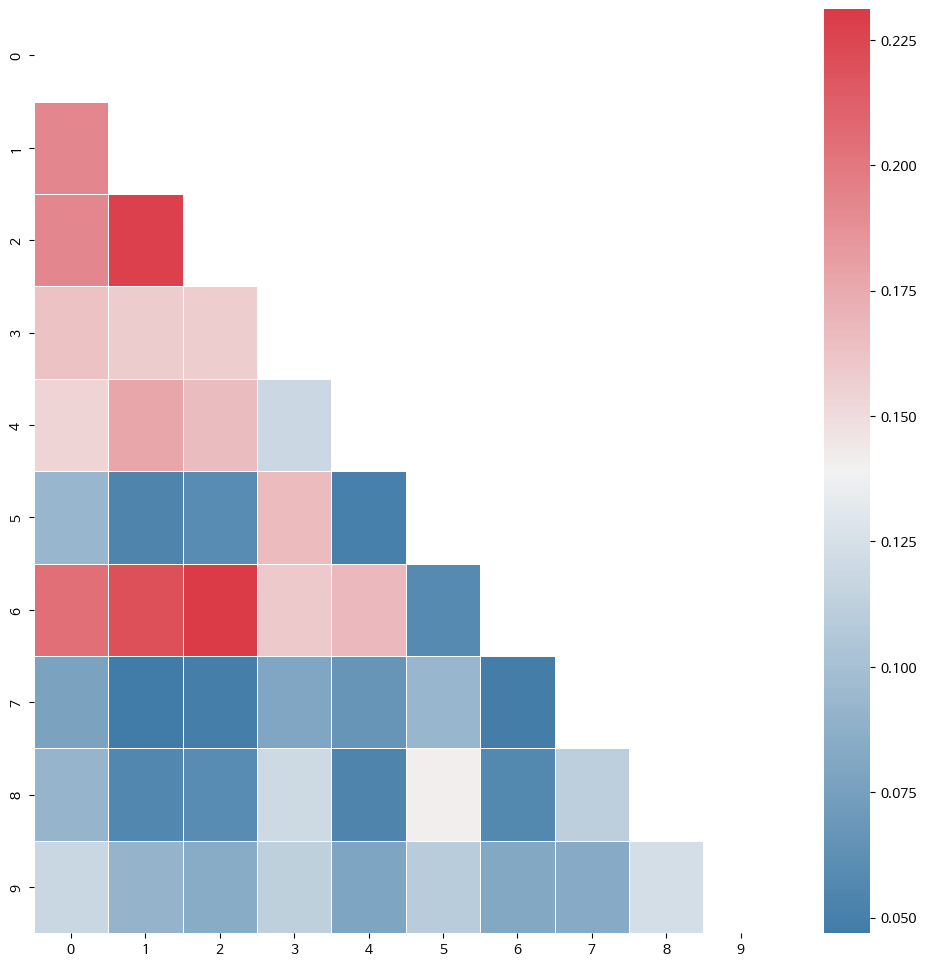

In [97]:
def sim_heatmap(sim_df):
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    plt.figure(figsize=(12,12))
    mask = np.zeros_like(sim_df, dtype=np.bool_)
    mask[np.triu_indices_from(mask)]=True
    sns.heatmap(sim_df, annot=False, cmap=cmap, mask=mask,
               linewidths=0.5, fmt='.2f', annot_kws={'size':8})
    plt.rc('font', family='NanumBarunGothic')
    plt.show()
sim_heatmap(sim_pair)

<strong>cluster_label=2인 문서들 간의 코사인 유사도¶

In [98]:
emotion_idx = doc_df[doc_df.cluster_label==2].index
docname = doc_df.iloc[emotion_idx[0]].filename
sim_pair = cosine_similarity(ftr_mat[emotion_idx], ftr_mat[emotion_idx])
print(f'{docname}과 다른 문서간의 유사도')
print(sim_pair.shape)

슬픔과 다른 문서간의 유사도
(4, 4)


<strong> barplot, heatmap</strong>
- cluster_label=2인 문서들 중 첫번째 문서와 다른 문서들간의 유사도 시각화

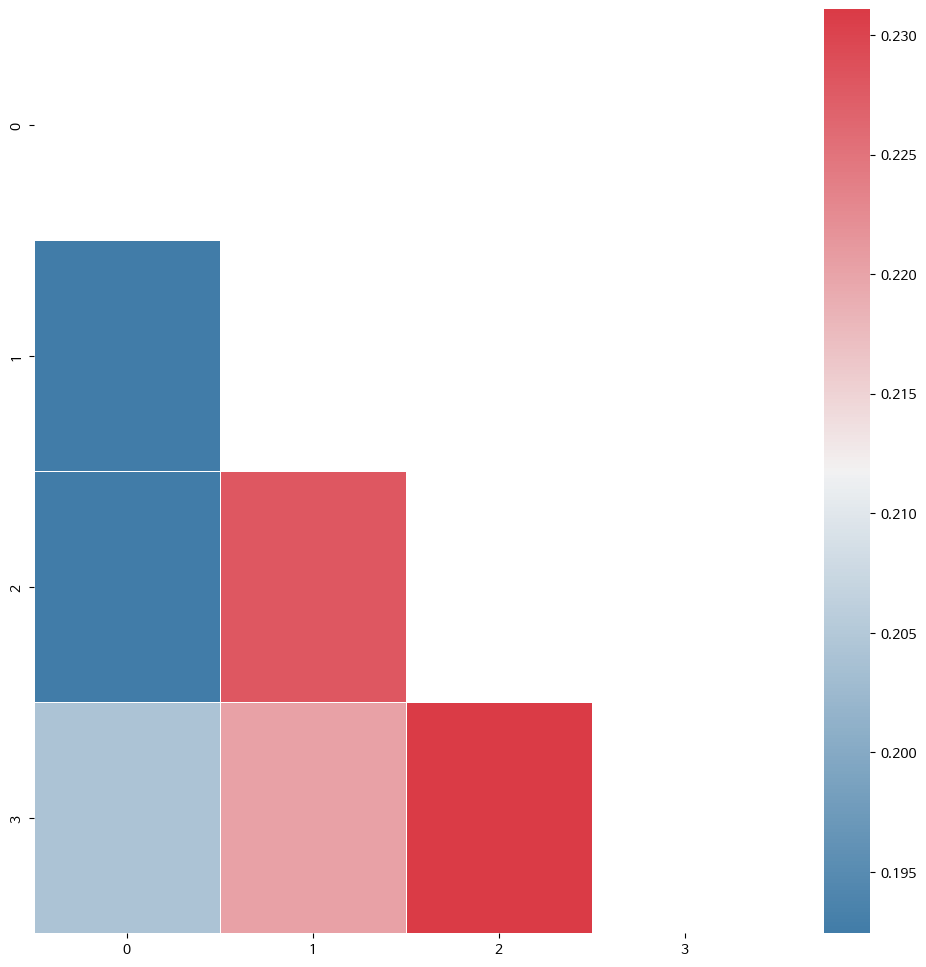

In [99]:
sim_heatmap(sim_pair)

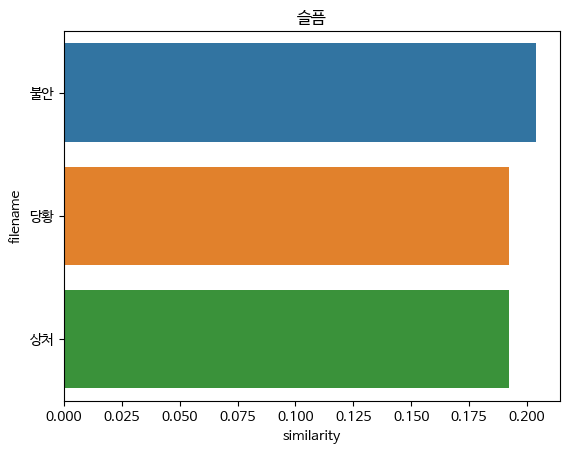

In [100]:
s_idx = sim_pair[0].argsort()[::-1]
doc_idx = list(emotion_idx[s_idx])
sim = sim_pair[0, s_idx[1:]]
idx = doc_df.iloc[emotion_idx[1:]].filename
sim_df = pd.DataFrame(data=sim, index = idx, columns=['similarity'])
sns.barplot(data=sim_df, x='similarity', y=sim_df.index)
plt.title(f'{doc_df.filename[doc_idx[0]]}')
plt.show()